<a href="https://colab.research.google.com/github/solaris0051/simpleNN/blob/main/in_1n_mid_12n_x4_out_1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **simpleNN**

##**neural network diagram**

nn.svg

## excutable codes 
(a series of results will show up anytime you make it fire.  )

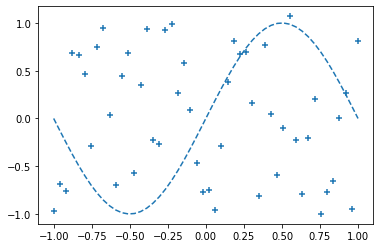

Epoch:0/1001 Error:0.549208809166458


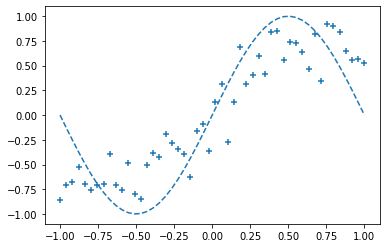

Epoch:50/1001 Error:0.06285440233294494


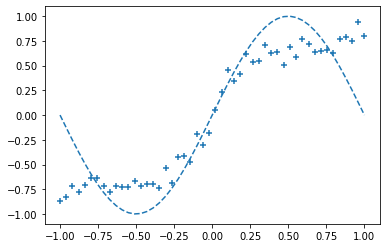

Epoch:100/1001 Error:0.05217447427195778


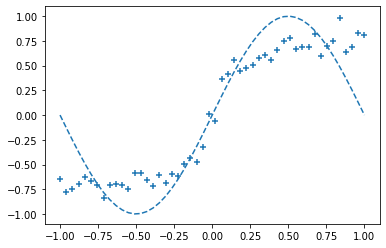

Epoch:150/1001 Error:0.04662574572529355


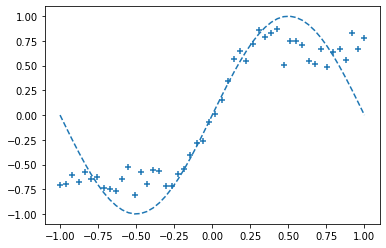

Epoch:200/1001 Error:0.04057699766506434


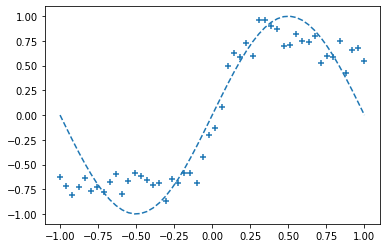

Epoch:250/1001 Error:0.03604605512816343


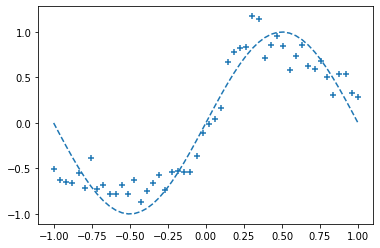

Epoch:300/1001 Error:0.025261359835794524


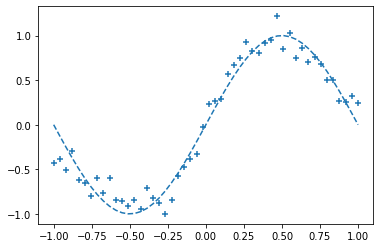

Epoch:350/1001 Error:0.011436419746092186


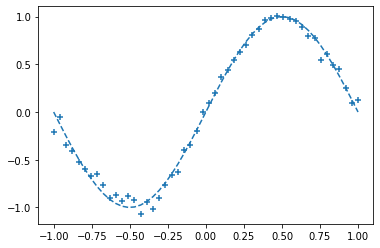

Epoch:400/1001 Error:0.0021746207721020485


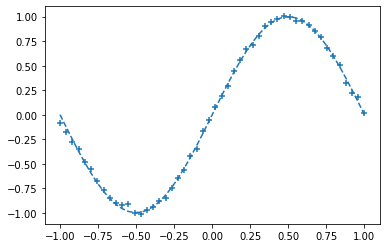

Epoch:450/1001 Error:0.0003532845408370897


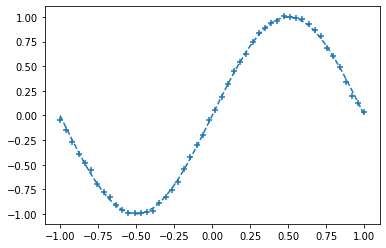

Epoch:500/1001 Error:0.00017635306235833204


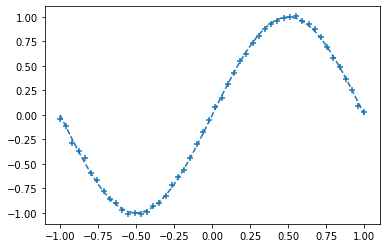

Epoch:550/1001 Error:0.0001653000102044212


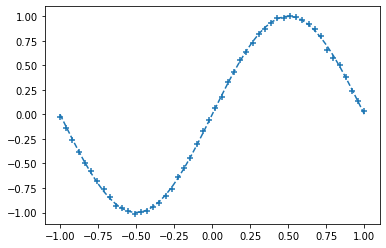

Epoch:600/1001 Error:9.538781221739779e-05


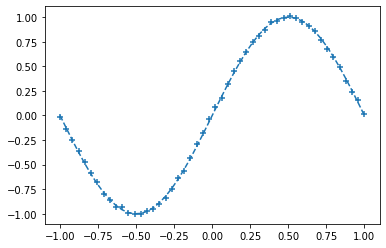

Epoch:650/1001 Error:8.913775733739238e-05


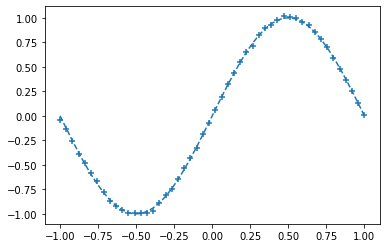

Epoch:700/1001 Error:6.686038161408679e-05


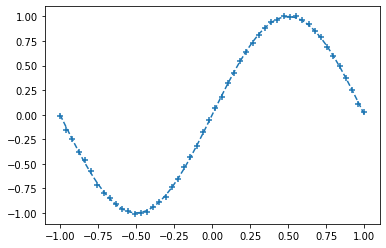

Epoch:750/1001 Error:6.508027780201062e-05


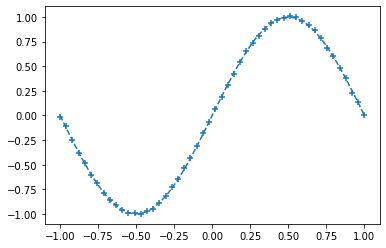

Epoch:800/1001 Error:3.290842256315025e-05


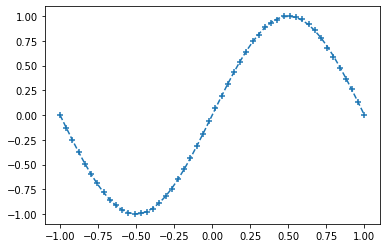

Epoch:850/1001 Error:1.96366179093944e-05


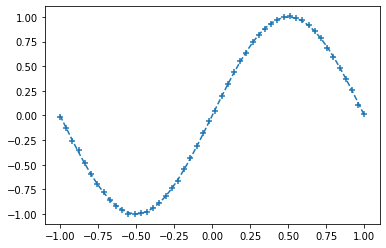

Epoch:900/1001 Error:3.8592388387885166e-05


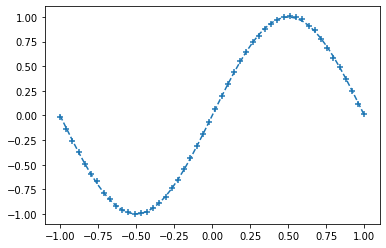

Epoch:950/1001 Error:2.76628780183962e-05


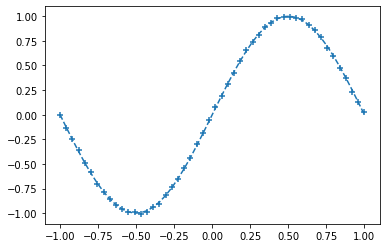

Epoch:1000/1001 Error:4.4906363290591654e-05


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -- input data and correct data --
input_data = np.linspace(-np.pi, np.pi)  # original input dataset
correct_data = np.sin(input_data)        # correct dataset
input_data = input_data/np.pi            # to range the realm from -1.0 to 1.0
n_data = len(correct_data)               # number of data

# -- config --
n_in = 1   # the number of neurons at the input layer
n_mid = 12 # the number of neurons at the middle layers
n_out = 1  # the number of neurons at the output layer

wb_width = 0.61  # width of weight and bias
eta = 0.15       # learning coefficient
epoch = 1001
interval = 50    # monitoring interval

# -- supercalss --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # weight matrix
        self.b = wb_width * np.random.randn(n)  # bias vector

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- middlelayer--
class MiddleLayer(BaseLayer):
    def forward(self, x):  # foreward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # sigmoid function(as activate function)

    def backward(self, grad_y):  # backward-propagation
        delta = grad_y * (1-self.y)*self.y  # differential calculus of sigmoid function

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)


# -- output layer --
class OutputLayer(BaseLayer):
    def forward(self, x):  # foreward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # identity function

    def backward(self, t):  # backward-propagation
        delta = self.y - t

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)


# -- initializing each layer --
middle_layer1 = MiddleLayer(n_in, n_mid)
middle_layer2 = MiddleLayer(n_mid, n_mid)
middle_layer3 = MiddleLayer(n_mid, n_mid)
middle_layer4 = MiddleLayer(n_mid, n_mid)

output_layer = OutputLayer(n_mid, n_out)

# -- start learning --
for i in range(epoch):

    # shffle index
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)

    # plot the results
    total_error = 0
    plot_x = []
    plot_y = []

    for idx in index_random:

        x = input_data[idx]  # original input dataset
        t = correct_data[idx]  # correct dataset

        # foreward-propagation
        middle_layer1.forward(np.array([[x]]))  # transform input data to middle layer1 to matrix
        middle_layer2.forward(middle_layer1.y)
        middle_layer3.forward(middle_layer2.y)
        middle_layer4.forward(middle_layer3.y)
        output_layer.forward(middle_layer4.y)

        # backward-propagation
        output_layer.backward(np.array([[t]]))  # express correct dataset as matrix
        middle_layer4.backward(output_layer.grad_x)
        middle_layer3.backward(middle_layer4.grad_x)
        middle_layer2.backward(middle_layer3.grad_x)
        middle_layer1.backward(middle_layer2.grad_x)

        # update wight and bias
        middle_layer1.update(eta)
        middle_layer2.update(eta)
        middle_layer3.update(eta)
        middle_layer4.update(eta)
        output_layer.update(eta)

        if i%interval == 0:

            y = output_layer.y[0][0]  # get numbers from matrix

            # error estimation
            total_error += 1.0/2.0*np.sum(np.square(y - t))  # mean square error

            # append outputs
            plot_x.append(x)
            plot_y.append(y)

    if i%interval == 0:

        # plot outpus
        plt.plot(input_data, correct_data, linestyle="dashed")
        plt.scatter(plot_x, plot_y, marker="+")
        plt.show()

        # print epoch number and errors
        print("Epoch:" + str(i) + "/" + str(epoch), "Error:" + str(total_error/n_data))